# 📊 Data Preparation for Early Warning System
## OULAD Dataset - Temporal Feature Engineering

---

**Module:** WM9QG-15 Fundamentals of AI and Data Mining

This notebook covers the **Data Preparation** phase of CRISP-DM, preparing the OULAD data for early warning classification.

---

## 📋 Data Preparation Steps Covered

| Step | Technique | Purpose |
|------|-----------|----------|
| 1 | Data Loading & Merging | Combine all OULAD tables |
| 2 | Missing Value Analysis | Identify and understand missing data |
| 3 | Missing Value Imputation | Fill missing values appropriately |
| 4 | Duplicate Handling | Remove redundant records |
| 5 | Outlier Detection & Treatment | Identify and cap extreme values |
| 6 | Feature Engineering | Create cumulative and derived features |
| 7 | Binning (Discretization) | Convert continuous to categorical |
| 8 | Encoding | One-hot and ordinal encoding |
| 9 | Feature Scaling | Standardize numerical features |
| 10 | Feature Selection | Select most relevant features |

---

## Key Innovation: Temporal Approach

This notebook creates **one row per student per week** with cumulative features, enabling predictions at any point during the course (early warning at week 2, 4, 6, etc.).

---

# 1️⃣ Setup and Data Loading

In [1]:
# =============================================================================
# IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from scipy import stats

# Settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Update this path to where your OULAD CSV files are located
DATA_DIR = Path(".")

# Key columns for joining tables (student + module combination)
KEY_COLS = ["student_id", "code_module", "code_presentation"]

print(f"Data directory: {DATA_DIR.resolve()}")

Data directory: C:\Users\mertf\Desktop\FAIDM\FAIDM_Groupwork


In [3]:
# =============================================================================
# LOAD ALL OULAD TABLES
# =============================================================================

def load_csv(name: str) -> pd.DataFrame:
    """Load a CSV file from the data directory."""
    return pd.read_csv(DATA_DIR / name)

print("Loading OULAD tables...")
print("-" * 60)

# Load all tables
assessments          = load_csv("assessments.csv")
courses              = load_csv("courses.csv")
student_assessment   = load_csv("studentAssessment.csv")
student_info         = load_csv("studentInfo.csv")
student_registration = load_csv("studentRegistration.csv")
student_vle          = load_csv("studentVle.csv")
vle                  = load_csv("vle.csv")

# Standardize column names: id_student → student_id (consistency)
student_assessment   = student_assessment.rename(columns={"id_student": "student_id"})
student_info         = student_info.rename(columns={"id_student": "student_id"})
student_registration = student_registration.rename(columns={"id_student": "student_id"})
student_vle          = student_vle.rename(columns={"id_student": "student_id"})

# Print summary
tables = {
    "assessments": assessments,
    "courses": courses,
    "student_assessment": student_assessment,
    "student_info": student_info,
    "student_registration": student_registration,
    "student_vle": student_vle,
    "vle": vle,
}

for name, df in tables.items():
    print(f"✓ {name}: {df.shape[0]:,} rows × {df.shape[1]} cols")

print("-" * 60)

Loading OULAD tables...
------------------------------------------------------------
✓ assessments: 206 rows × 6 cols
✓ courses: 22 rows × 3 cols
✓ student_assessment: 173,912 rows × 5 cols
✓ student_info: 32,593 rows × 12 cols
✓ student_registration: 32,593 rows × 5 cols
✓ student_vle: 10,655,280 rows × 6 cols
✓ vle: 6,364 rows × 6 cols
------------------------------------------------------------


---

# 2️⃣ Missing Value Analysis

Before any cleaning, we must understand the extent and patterns of missing data.

In [4]:
# =============================================================================
# MISSING VALUE ANALYSIS FOR EACH TABLE
# =============================================================================

print("MISSING VALUE ANALYSIS")
print("=" * 60)

for name, df in tables.items():
    missing = df.isna().sum()
    missing_cols = missing[missing > 0]
    
    if len(missing_cols) > 0:
        print(f"\n{name}:")
        for col, count in missing_cols.items():
            pct = count / len(df) * 100
            print(f"  • {col}: {count:,} missing ({pct:.1f}%)")
    else:
        print(f"\n{name}: ✓ No missing values")

print("\n" + "=" * 60)

MISSING VALUE ANALYSIS

assessments:
  • date: 11 missing (5.3%)

courses: ✓ No missing values

student_assessment:
  • score: 173 missing (0.1%)

student_info:
  • imd_band: 1,111 missing (3.4%)

student_registration:
  • date_registration: 45 missing (0.1%)
  • date_unregistration: 22,521 missing (69.1%)

student_vle: ✓ No missing values

vle:
  • week_from: 5,243 missing (82.4%)
  • week_to: 5,243 missing (82.4%)



In [5]:
# =============================================================================
# DETAILED ANALYSIS: student_info (main demographics table)
# =============================================================================

print("Detailed Missing Analysis: student_info")
print("-" * 60)

# Check imd_band specifically (common missing field)
if 'imd_band' in student_info.columns:
    missing_imd = student_info['imd_band'].isna().sum()
    print(f"imd_band missing: {missing_imd} ({missing_imd/len(student_info)*100:.1f}%)")
    print(f"\nimd_band value counts:")
    print(student_info['imd_band'].value_counts(dropna=False))

Detailed Missing Analysis: student_info
------------------------------------------------------------
imd_band missing: 1111 (3.4%)

imd_band value counts:
imd_band
20-30%     3654
30-40%     3539
10-20      3516
0-10%      3311
40-50%     3256
50-60%     3124
60-70%     2905
70-80%     2879
80-90%     2762
90-100%    2536
NaN        1111
Name: count, dtype: int64


---

# 3️⃣ Build Base Feature Tables

## 3.1 Demographics (Static Features)

In [6]:
# =============================================================================
# DEMOGRAPHICS TABLE
# =============================================================================

demographics = student_info[KEY_COLS + [
    "gender",
    "region",
    "highest_education",
    "imd_band",
    "age_band",
    "num_of_prev_attempts",
    "studied_credits",
    "disability",
]].copy()

print(f"Demographics shape: {demographics.shape}")
print(f"\nColumn types:")
print(demographics.dtypes)

Demographics shape: (32593, 11)

Column types:
student_id               int64
code_module             object
code_presentation       object
gender                  object
region                  object
highest_education       object
imd_band                object
age_band                object
num_of_prev_attempts     int64
studied_credits          int64
disability              object
dtype: object


## 3.2 Course Features

In [7]:
# =============================================================================
# COURSE FEATURES
# =============================================================================

course_features = courses[[
    "code_module", 
    "code_presentation", 
    "module_presentation_length"
]].copy()

print(f"Course features shape: {course_features.shape}")
print(f"\nModule presentation lengths:")
print(course_features.groupby('code_module')['module_presentation_length'].first())

Course features shape: (22, 3)

Module presentation lengths:
code_module
AAA    268
BBB    268
CCC    269
DDD    261
EEE    268
FFF    268
GGG    261
Name: module_presentation_length, dtype: int64


## 3.3 Registration Features

In [8]:
# =============================================================================
# REGISTRATION FEATURES
# =============================================================================

registration_features = student_registration[KEY_COLS + [
    "date_registration",
    "date_unregistration",
]].copy()

print(f"Registration features shape: {registration_features.shape}")
print(f"\ndate_registration stats:")
print(registration_features['date_registration'].describe())

Registration features shape: (32593, 5)

date_registration stats:
count    32548.000000
mean       -69.411300
std         49.260522
min       -322.000000
25%       -100.000000
50%        -57.000000
75%        -29.000000
max        167.000000
Name: date_registration, dtype: float64


## 3.4 Target Variables

In [9]:
# =============================================================================
# TARGET VARIABLES
# =============================================================================

# Classification target: Pass/Distinction = 1, Fail/Withdrawn = 0
targets = student_info[KEY_COLS + ["final_result"]].copy()
targets["target_pass"] = targets["final_result"].isin(["Pass", "Distinction"]).astype(int)

# Regression target: Weighted average score
score_df = (
    student_assessment
    .merge(assessments[["id_assessment", "code_module", "code_presentation", "weight"]], 
           on="id_assessment", how="left")
)

# Aggregate to student level
score_agg = (
    score_df
    .groupby(KEY_COLS)
    .apply(lambda g: pd.Series({
        "target_score": np.average(g["score"].fillna(0), weights=g["weight"].fillna(1)) if g["weight"].sum() > 0 else np.nan,
        "weight_covered": g["weight"].sum()
    }))
    .reset_index()
)

targets = targets.merge(score_agg, on=KEY_COLS, how="left")

print("Target Distribution:")
print(targets["target_pass"].value_counts())
print(f"\nSuccess rate: {targets['target_pass'].mean()*100:.1f}%")

Target Distribution:
target_pass
0    17208
1    15385
Name: count, dtype: int64

Success rate: 47.2%


---

# 4️⃣ Feature Engineering: Weekly VLE Features

This is the **key innovation** of the temporal approach: creating cumulative features by week.

In [10]:
# =============================================================================
# STEP 1: Add activity type and convert dates to weeks
# =============================================================================

print("Building weekly VLE features...")
print("-" * 60)

# Merge activity type into student_vle
vle_interactions = student_vle.merge(
    vle[["id_site", "code_module", "code_presentation", "activity_type"]],
    on=["id_site", "code_module", "code_presentation"],
    how="left"
)

# Convert date (days from start) to week number
vle_interactions["week"] = (vle_interactions["date"] // 7).astype(int)

print(f"VLE interactions: {vle_interactions.shape[0]:,} rows")
print(f"Week range: {vle_interactions['week'].min()} to {vle_interactions['week'].max()}")
print(f"Activity types: {vle_interactions['activity_type'].nunique()}")

Building weekly VLE features...
------------------------------------------------------------
VLE interactions: 10,655,280 rows
Week range: -4 to 38
Activity types: 20


In [11]:
# =============================================================================
# STEP 2: Aggregate by student × week × activity type
# =============================================================================

weekly_by_type = (
    vle_interactions
    .groupby(KEY_COLS + ["week", "activity_type"])
    .agg(
        weekly_clicks=("sum_click", "sum"),
        weekly_active_days=("date", "nunique"),
        weekly_n_resources=("id_site", "nunique"),
    )
    .reset_index()
)

print(f"Weekly aggregates: {weekly_by_type.shape}")

Weekly aggregates: (2518170, 8)


In [12]:
# =============================================================================
# STEP 3: Pivot to wide format (one column per activity type)
# =============================================================================

def pivot_metric(df: pd.DataFrame, value_col: str, prefix: str) -> pd.DataFrame:
    """Pivot a metric to wide format with activity types as columns."""
    wide = (
        df.pivot_table(
            index=KEY_COLS + ["week"],
            columns="activity_type",
            values=value_col,
            aggfunc="sum",
            fill_value=0,
        )
        .reset_index()
    )
    # Rename columns to include prefix
    wide.columns = [
        f"{prefix}_{c}".lower().replace(" ", "_")
        if c not in KEY_COLS + ["week"] else c
        for c in wide.columns
    ]
    return wide

# Pivot each metric
weekly_clicks_wide = pivot_metric(weekly_by_type, "weekly_clicks", "weekly_clicks")
weekly_days_wide   = pivot_metric(weekly_by_type, "weekly_active_days", "weekly_days")
weekly_res_wide    = pivot_metric(weekly_by_type, "weekly_n_resources", "weekly_resources")

# Merge all weekly metrics
weekly_wide = (
    weekly_clicks_wide
    .merge(weekly_days_wide, on=KEY_COLS + ["week"], how="left")
    .merge(weekly_res_wide, on=KEY_COLS + ["week"], how="left")
)

print(f"Weekly wide format: {weekly_wide.shape}")

Weekly wide format: (627031, 64)


In [13]:
# =============================================================================
# STEP 4: Compute CUMULATIVE features
# =============================================================================
# At week t, cumulative = sum of all activity from week 0 to week t
# This captures the student's trajectory over time
# =============================================================================

weekly_wide = weekly_wide.sort_values(KEY_COLS + ["week"]).copy()

# Get all weekly feature columns
weekly_feature_cols = [c for c in weekly_wide.columns if c not in KEY_COLS + ["week"]]

# Create cumulative column names
cum_cols = ["cum_" + c for c in weekly_feature_cols]

# Compute cumulative sum within each student
weekly_wide[cum_cols] = (
    weekly_wide
    .groupby(KEY_COLS)[weekly_feature_cols]
    .cumsum()
)

# Also compute total cumulative clicks (aggregated across all activity types)
click_cols = [c for c in cum_cols if 'clicks' in c]
weekly_wide['cum_total_clicks'] = weekly_wide[click_cols].sum(axis=1)

# Keep only cumulative features
ews_features = weekly_wide[KEY_COLS + ["week"] + cum_cols + ['cum_total_clicks']].copy()

print(f"EWS features (cumulative): {ews_features.shape}")
print(f"Cumulative columns: {len(cum_cols) + 1}")

EWS features (cumulative): (627031, 65)
Cumulative columns: 61


---

# 5️⃣ Merge All Features into Feature Store

In [14]:
# =============================================================================
# BUILD COMPLETE FEATURE STORE
# =============================================================================

feature_store = (
    ews_features
    .merge(demographics, on=KEY_COLS, how="left")
    .merge(course_features, on=["code_module", "code_presentation"], how="left")
    .merge(registration_features, on=KEY_COLS, how="left")
    .merge(targets, on=KEY_COLS, how="left")
)

print("=" * 60)
print("FEATURE STORE CREATED")
print("=" * 60)
print(f"Shape: {feature_store.shape[0]:,} rows × {feature_store.shape[1]} columns")
print(f"Unique students: {feature_store['student_id'].nunique():,}")
print(f"Week range: {feature_store['week'].min()} to {feature_store['week'].max()}")
print("=" * 60)

FEATURE STORE CREATED
Shape: 627,031 rows × 80 columns
Unique students: 26,074
Week range: -4 to 38


---

# 6️⃣ Data Cleaning

## 6.1 Handle Duplicates

In [15]:
# =============================================================================
# CHECK AND REMOVE DUPLICATES
# =============================================================================

print("DUPLICATE HANDLING")
print("-" * 60)

n_before = len(feature_store)
n_duplicates = feature_store.duplicated().sum()
print(f"Duplicate rows found: {n_duplicates}")

if n_duplicates > 0:
    feature_store = feature_store.drop_duplicates()
    print(f"Removed {n_duplicates} duplicates")
    print(f"Rows: {n_before:,} → {len(feature_store):,}")
else:
    print("✓ No duplicates found")

print("-" * 60)

DUPLICATE HANDLING
------------------------------------------------------------
Duplicate rows found: 0
✓ No duplicates found
------------------------------------------------------------


## 6.2 Remove Invalid Records

In [16]:
# =============================================================================
# REMOVE INVALID RECORDS
# =============================================================================

print("REMOVING INVALID RECORDS")
print("-" * 60)

n_before = len(feature_store)

# 1. Remove rows with missing target
feature_store = feature_store[feature_store['target_pass'].notna()]
print(f"After removing missing target: {len(feature_store):,}")

# 2. Remove students who withdrew before course started (date_unregistration < 1)
mask_early_withdraw = (
    feature_store['date_unregistration'].notna() & 
    (feature_store['date_unregistration'] < 1)
)
feature_store = feature_store[~mask_early_withdraw]
print(f"After removing early withdrawals: {len(feature_store):,}")

print(f"\nTotal removed: {n_before - len(feature_store):,} rows")
print("-" * 60)

REMOVING INVALID RECORDS
------------------------------------------------------------
After removing missing target: 627,031
After removing early withdrawals: 625,294

Total removed: 1,737 rows
------------------------------------------------------------


## 6.3 Missing Value Imputation

In [17]:
# =============================================================================
# MISSING VALUE ANALYSIS AFTER MERGE
# =============================================================================

print("MISSING VALUES IN FEATURE STORE")
print("-" * 60)

missing = feature_store.isna().sum()
missing_cols = missing[missing > 0].sort_values(ascending=False)

if len(missing_cols) > 0:
    print("Columns with missing values:")
    for col in missing_cols.index:
        pct = missing_cols[col] / len(feature_store) * 100
        print(f"  • {col}: {missing_cols[col]:,} ({pct:.1f}%)")
else:
    print("✓ No missing values")

print("-" * 60)

MISSING VALUES IN FEATURE STORE
------------------------------------------------------------
Columns with missing values:
  • date_unregistration: 561,388 (89.8%)
  • target_score: 51,872 (8.3%)
  • imd_band: 28,911 (4.6%)
  • weight_covered: 9,783 (1.6%)
  • date_registration: 3 (0.0%)
------------------------------------------------------------


In [18]:
# =============================================================================
# IMPUTE MISSING VALUES
# =============================================================================

print("IMPUTING MISSING VALUES")
print("-" * 60)

# 1. imd_band: Create missing indicator + fill with 'Unknown'
if 'imd_band' in feature_store.columns:
    feature_store['imd_band_missing'] = feature_store['imd_band'].isna().astype(int)
    feature_store['imd_band'] = feature_store['imd_band'].fillna('Unknown')
    print("✓ imd_band: Created missing indicator, filled with 'Unknown'")

# 2. Cumulative VLE features: Fill with 0 (no activity = 0 clicks)
cum_vle_cols = [c for c in feature_store.columns if c.startswith('cum_')]
feature_store[cum_vle_cols] = feature_store[cum_vle_cols].fillna(0)
print(f"✓ Cumulative VLE columns ({len(cum_vle_cols)}): Filled with 0")

# 3. Numerical columns: Impute with MEDIAN (robust to outliers)
num_cols_to_impute = ['date_registration', 'studied_credits', 'num_of_prev_attempts', 
                      'module_presentation_length']
num_cols_to_impute = [c for c in num_cols_to_impute if c in feature_store.columns]

if num_cols_to_impute:
    imputer = SimpleImputer(strategy='median')
    cols_with_missing = [c for c in num_cols_to_impute if feature_store[c].isna().any()]
    if cols_with_missing:
        feature_store[cols_with_missing] = imputer.fit_transform(feature_store[cols_with_missing])
        print(f"✓ Numerical columns: Imputed with MEDIAN")

# 4. Categorical columns: Fill with mode or 'Unknown'
cat_cols = ['gender', 'region', 'highest_education', 'age_band', 'disability']
for col in cat_cols:
    if col in feature_store.columns and feature_store[col].isna().any():
        mode_val = feature_store[col].mode()[0] if len(feature_store[col].mode()) > 0 else 'Unknown'
        feature_store[col] = feature_store[col].fillna(mode_val)
        print(f"✓ {col}: Filled with mode ('{mode_val}')")

# Verify no missing values remain (except for regression target which we don't use)
remaining_missing = feature_store.drop(columns=['target_score', 'weight_covered', 'date_unregistration'], errors='ignore').isna().sum().sum()
print(f"\n✓ Remaining missing values: {remaining_missing}")
print("-" * 60)

IMPUTING MISSING VALUES
------------------------------------------------------------
✓ imd_band: Created missing indicator, filled with 'Unknown'
✓ Cumulative VLE columns (61): Filled with 0
✓ Numerical columns: Imputed with MEDIAN

✓ Remaining missing values: 0
------------------------------------------------------------


---

# 7️⃣ Outlier Detection and Treatment

In [19]:
# =============================================================================
# OUTLIER DETECTION USING IQR METHOD
# =============================================================================

print("OUTLIER DETECTION (IQR Method)")
print("-" * 60)

def detect_outliers_iqr(series):
    """Detect outliers using IQR method."""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((series < lower) | (series > upper)).sum()
    return outliers, lower, upper

# Check key numerical columns
cols_to_check = ['cum_total_clicks', 'studied_credits', 'num_of_prev_attempts', 'date_registration']
cols_to_check = [c for c in cols_to_check if c in feature_store.columns]

print("Outlier counts:")
for col in cols_to_check:
    n_outliers, lower, upper = detect_outliers_iqr(feature_store[col])
    pct = n_outliers / len(feature_store) * 100
    print(f"  • {col}: {n_outliers:,} outliers ({pct:.1f}%)")

print("-" * 60)

OUTLIER DETECTION (IQR Method)
------------------------------------------------------------
Outlier counts:
  • cum_total_clicks: 48,373 outliers (7.7%)
  • studied_credits: 32,180 outliers (5.1%)
  • num_of_prev_attempts: 65,611 outliers (10.5%)
  • date_registration: 6,389 outliers (1.0%)
------------------------------------------------------------


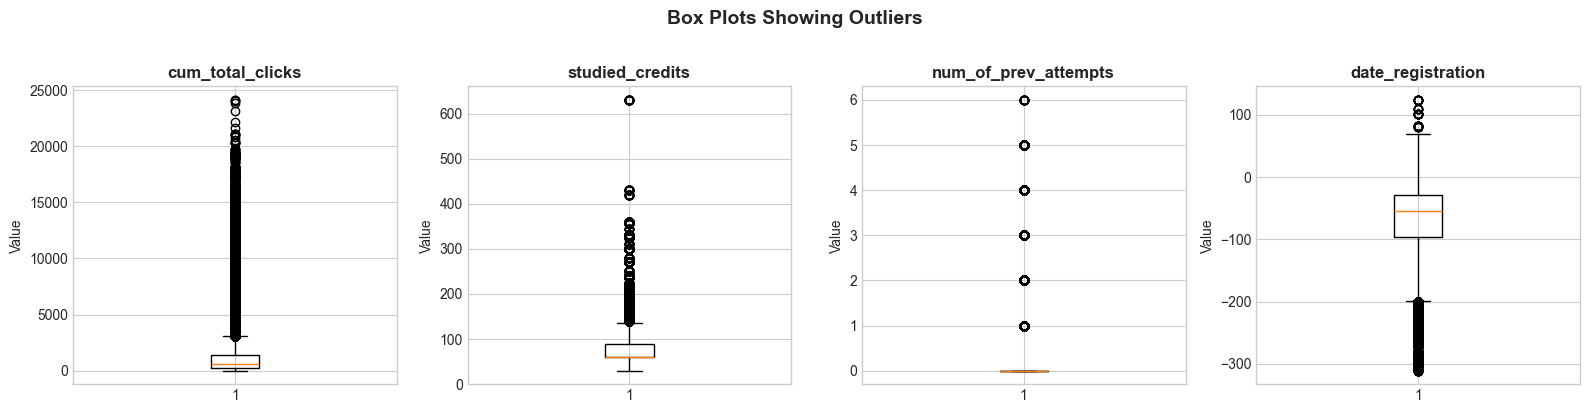

In [20]:
# =============================================================================
# VISUALIZE OUTLIERS
# =============================================================================

fig, axes = plt.subplots(1, len(cols_to_check), figsize=(4*len(cols_to_check), 4))
if len(cols_to_check) == 1:
    axes = [axes]

for i, col in enumerate(cols_to_check):
    axes[i].boxplot(feature_store[col].dropna())
    axes[i].set_title(f'{col}', fontweight='bold')
    axes[i].set_ylabel('Value')

plt.suptitle('Box Plots Showing Outliers', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [21]:
# =============================================================================
# OUTLIER TREATMENT: CAPPING AT 99TH PERCENTILE
# =============================================================================

print("OUTLIER TREATMENT (Capping at 99th percentile)")
print("-" * 60)

# Cap cumulative click columns (most likely to have extreme outliers)
cols_to_cap = [c for c in feature_store.columns if c.startswith('cum_') and 'clicks' in c]

for col in cols_to_cap:
    p99 = feature_store[col].quantile(0.99)
    n_capped = (feature_store[col] > p99).sum()
    if n_capped > 0:
        feature_store[col] = feature_store[col].clip(upper=p99)
        print(f"✓ {col}: Capped {n_capped:,} values at {p99:.0f}")

print("-" * 60)

OUTLIER TREATMENT (Capping at 99th percentile)
------------------------------------------------------------
✓ cum_weekly_clicks_dataplus: Capped 6,062 values at 25
✓ cum_weekly_clicks_dualpane: Capped 5,952 values at 13
✓ cum_weekly_clicks_externalquiz: Capped 5,908 values at 31
✓ cum_weekly_clicks_folder: Capped 4,621 values at 2
✓ cum_weekly_clicks_forumng: Capped 6,252 values at 2464
✓ cum_weekly_clicks_glossary: Capped 6,217 values at 38
✓ cum_weekly_clicks_homepage: Capped 6,249 values at 1250
✓ cum_weekly_clicks_htmlactivity: Capped 5,030 values at 8
✓ cum_weekly_clicks_oucollaborate: Capped 5,872 values at 34
✓ cum_weekly_clicks_oucontent: Capped 6,246 values at 2436
✓ cum_weekly_clicks_ouelluminate: Capped 6,202 values at 31
✓ cum_weekly_clicks_ouwiki: Capped 6,236 values at 357
✓ cum_weekly_clicks_page: Capped 5,484 values at 23
✓ cum_weekly_clicks_questionnaire: Capped 5,982 values at 30
✓ cum_weekly_clicks_quiz: Capped 6,238 values at 1546
✓ cum_weekly_clicks_repeatactivity:

---

# 8️⃣ Feature Engineering: Derived Features

In [22]:
# =============================================================================
# RATIO FEATURES
# =============================================================================

print("CREATING DERIVED FEATURES")
print("-" * 60)

# 1. Clicks per active day (engagement intensity)
days_cols = [c for c in feature_store.columns if 'cum_weekly_days' in c]
if days_cols:
    total_active_days = feature_store[days_cols].sum(axis=1).replace(0, 1)  # Avoid division by zero
    feature_store['clicks_per_day'] = feature_store['cum_total_clicks'] / total_active_days
    print("✓ Created: clicks_per_day (engagement intensity)")

# 2. Early registration flag (registered before course started)
if 'date_registration' in feature_store.columns:
    feature_store['registered_early'] = (feature_store['date_registration'] < 0).astype(int)
    print("✓ Created: registered_early (binary flag)")

# 3. Has previous attempts flag
if 'num_of_prev_attempts' in feature_store.columns:
    feature_store['has_prev_attempts'] = (feature_store['num_of_prev_attempts'] > 0).astype(int)
    print("✓ Created: has_prev_attempts (binary flag)")

# 4. High credit load flag
if 'studied_credits' in feature_store.columns:
    median_credits = feature_store['studied_credits'].median()
    feature_store['high_credit_load'] = (feature_store['studied_credits'] > median_credits).astype(int)
    print("✓ Created: high_credit_load (binary flag)")

# 5. Week relative to course length (progress indicator)
if 'module_presentation_length' in feature_store.columns:
    feature_store['week_progress'] = feature_store['week'] / (feature_store['module_presentation_length'] / 7)
    print("✓ Created: week_progress (relative progress)")

print("-" * 60)

CREATING DERIVED FEATURES
------------------------------------------------------------
✓ Created: clicks_per_day (engagement intensity)
✓ Created: registered_early (binary flag)
✓ Created: has_prev_attempts (binary flag)
✓ Created: high_credit_load (binary flag)
✓ Created: week_progress (relative progress)
------------------------------------------------------------


---

# 9️⃣ Binning (Discretization)

In [23]:
# =============================================================================
# BINNING WITH pd.cut()
# =============================================================================

print("BINNING CONTINUOUS VARIABLES")
print("-" * 60)

# 1. Engagement level bins (based on cumulative clicks)
feature_store['engagement_level'] = pd.cut(
    feature_store['cum_total_clicks'],
    bins=[0, 50, 200, 500, 1000, float('inf')],
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
    include_lowest=True
)
print("✓ Created: engagement_level (5 bins)")
print(f"   Distribution: {feature_store['engagement_level'].value_counts().to_dict()}")

# 2. Credits load bins
if 'studied_credits' in feature_store.columns:
    feature_store['credits_band'] = pd.cut(
        feature_store['studied_credits'],
        bins=[0, 60, 120, 180, float('inf')],
        labels=['Light', 'Normal', 'Heavy', 'Very Heavy'],
        include_lowest=True
    )
    print("\n✓ Created: credits_band (4 bins)")
    print(f"   Distribution: {feature_store['credits_band'].value_counts().to_dict()}")

# 3. Registration timing bins
if 'date_registration' in feature_store.columns:
    feature_store['registration_timing'] = pd.cut(
        feature_store['date_registration'],
        bins=[-float('inf'), -30, -7, 0, 14, float('inf')],
        labels=['Very Early', 'Early', 'On Time', 'Late', 'Very Late'],
    )
    print("\n✓ Created: registration_timing (5 bins)")
    print(f"   Distribution: {feature_store['registration_timing'].value_counts().to_dict()}")

print("-" * 60)

BINNING CONTINUOUS VARIABLES
------------------------------------------------------------
✓ Created: engagement_level (5 bins)
   Distribution: {'Very High': 217471, 'High': 136345, 'Medium': 135304, 'Low': 88314, 'Very Low': 47860}

✓ Created: credits_band (4 bins)
   Distribution: {'Light': 414688, 'Normal': 177103, 'Heavy': 26940, 'Very Heavy': 6563}

✓ Created: registration_timing (5 bins)
   Distribution: {'Very Early': 462483, 'Early': 153146, 'On Time': 5863, 'Late': 2942, 'Very Late': 860}
------------------------------------------------------------


---

# 🔟 Encoding Categorical Variables

In [24]:
# =============================================================================
# ORDINAL ENCODING (for ordered categories)
# =============================================================================

print("ENCODING CATEGORICAL VARIABLES")
print("-" * 60)

# 1. Highest education (ordinal - has natural order)
education_order = {
    'No Formal quals': 0,
    'Lower Than A Level': 1,
    'A Level or Equivalent': 2,
    'HE Qualification': 3,
    'Post Graduate Qualification': 4
}
if 'highest_education' in feature_store.columns:
    feature_store['education_level'] = feature_store['highest_education'].map(education_order)
    print("✓ Ordinal encoded: highest_education → education_level")

# 2. Age band (ordinal)
age_order = {'0-35': 0, '35-55': 1, '55<=': 2}
if 'age_band' in feature_store.columns:
    feature_store['age_level'] = feature_store['age_band'].map(age_order)
    print("✓ Ordinal encoded: age_band → age_level")

# 3. IMD band (ordinal - deprivation index)
if 'imd_band' in feature_store.columns:
    imd_order = {
        '0-10%': 0, '10-20': 1, '10-20%': 1, '20-30%': 2, '30-40%': 3,
        '40-50%': 4, '50-60%': 5, '60-70%': 6, '70-80%': 7, '80-90%': 8, '90-100%': 9,
        'Unknown': 5  # Median
    }
    feature_store['imd_level'] = feature_store['imd_band'].map(imd_order).fillna(5)
    print("✓ Ordinal encoded: imd_band → imd_level")

# 4. Engagement level (ordinal)
engagement_order = {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
feature_store['engagement_level_encoded'] = feature_store['engagement_level'].map(engagement_order)
print("✓ Ordinal encoded: engagement_level → engagement_level_encoded")

print("-" * 60)

ENCODING CATEGORICAL VARIABLES
------------------------------------------------------------
✓ Ordinal encoded: highest_education → education_level
✓ Ordinal encoded: age_band → age_level
✓ Ordinal encoded: imd_band → imd_level
✓ Ordinal encoded: engagement_level → engagement_level_encoded
------------------------------------------------------------


In [25]:
# =============================================================================
# ONE-HOT ENCODING (for nominal categories)
# =============================================================================

print("ONE-HOT ENCODING")
print("-" * 60)

# Columns to one-hot encode (nominal - no natural order)
nominal_cols = ['gender', 'disability']

for col in nominal_cols:
    if col in feature_store.columns:
        dummies = pd.get_dummies(feature_store[col], prefix=col, drop_first=True)
        feature_store = pd.concat([feature_store, dummies], axis=1)
        print(f"✓ One-hot encoded: {col} → {list(dummies.columns)}")

print("-" * 60)

ONE-HOT ENCODING
------------------------------------------------------------
✓ One-hot encoded: gender → ['gender_M']
✓ One-hot encoded: disability → ['disability_Y']
------------------------------------------------------------


---

# 1️⃣1️⃣ Feature Scaling

In [26]:
# =============================================================================
# IDENTIFY NUMERICAL FEATURES FOR SCALING
# =============================================================================

print("FEATURE SCALING (StandardScaler)")
print("-" * 60)

# Columns that should be scaled (numerical features used for modelling)
# Exclude: IDs, targets, categorical, encoded ordinals (already 0-n), binary flags
exclude_from_scaling = [
    'student_id', 'code_module', 'code_presentation', 'week',
    'target_pass', 'target_score', 'weight_covered', 'final_result',
    'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability',
    'engagement_level', 'credits_band', 'registration_timing',
    'date_unregistration'
]

# Binary/encoded columns (don't scale)
binary_cols = [c for c in feature_store.columns if 
               c.endswith('_missing') or c.endswith('_encoded') or
               c.startswith('gender_') or c.startswith('disability_') or
               c in ['registered_early', 'has_prev_attempts', 'high_credit_load', 'imd_band_missing']]

exclude_from_scaling.extend(binary_cols)

# Get columns to scale
numerical_cols_to_scale = [
    c for c in feature_store.select_dtypes(include=[np.number]).columns
    if c not in exclude_from_scaling
]

print(f"Columns to scale: {len(numerical_cols_to_scale)}")
print(f"Sample: {numerical_cols_to_scale[:5]}...")

FEATURE SCALING (StandardScaler)
------------------------------------------------------------
Columns to scale: 70
Sample: ['cum_weekly_clicks_dataplus', 'cum_weekly_clicks_dualpane', 'cum_weekly_clicks_externalquiz', 'cum_weekly_clicks_folder', 'cum_weekly_clicks_forumng']...


In [27]:
# =============================================================================
# APPLY STANDARD SCALING
# =============================================================================

# Create scaled versions with _scaled suffix
scaler = StandardScaler()

# Fit and transform
scaled_data = scaler.fit_transform(feature_store[numerical_cols_to_scale])
scaled_df = pd.DataFrame(
    scaled_data,
    columns=[f"{c}_scaled" for c in numerical_cols_to_scale],
    index=feature_store.index
)

# Add scaled columns to feature store
feature_store = pd.concat([feature_store, scaled_df], axis=1)

print(f"✓ Created {len(numerical_cols_to_scale)} scaled features")
print(f"\nExample - cum_total_clicks:")
print(f"  Original: mean={feature_store['cum_total_clicks'].mean():.2f}, std={feature_store['cum_total_clicks'].std():.2f}")
print(f"  Scaled:   mean={feature_store['cum_total_clicks_scaled'].mean():.2f}, std={feature_store['cum_total_clicks_scaled'].std():.2f}")
print("-" * 60)

✓ Created 70 scaled features

Example - cum_total_clicks:
  Original: mean=1077.14, std=1285.91
  Scaled:   mean=0.00, std=1.00
------------------------------------------------------------


---

# 1️⃣2️⃣ Feature Selection

In [28]:
# =============================================================================
# CORRELATION WITH TARGET
# =============================================================================

print("FEATURE SELECTION BY CORRELATION")
print("-" * 60)

# Get all numerical features (excluding IDs, targets, etc.)
feature_cols = [
    c for c in feature_store.select_dtypes(include=[np.number]).columns
    if c not in ['student_id', 'target_pass', 'target_score', 'weight_covered', 'week']
]

# Calculate correlation with target
correlations = feature_store[feature_cols + ['target_pass']].corr()['target_pass'].drop('target_pass')
correlations_sorted = correlations.abs().sort_values(ascending=False)

print("Top 20 features by |correlation| with target:")
for i, (feat, corr) in enumerate(correlations_sorted.head(20).items(), 1):
    direction = '+' if correlations[feat] > 0 else '-'
    print(f"  {i:2}. {feat}: {direction}{corr:.4f}")

print("-" * 60)

FEATURE SELECTION BY CORRELATION
------------------------------------------------------------
Top 20 features by |correlation| with target:
   1. cum_weekly_resources_homepage: +0.2895
   2. cum_weekly_resources_homepage_scaled: +0.2895
   3. cum_weekly_days_homepage_scaled: +0.2758
   4. cum_weekly_days_homepage: +0.2758
   5. week_progress_scaled: +0.2558
   6. week_progress: +0.2558
   7. cum_total_clicks: +0.2341
   8. cum_total_clicks_scaled: +0.2341
   9. cum_weekly_resources_forumng_scaled: +0.2338
  10. cum_weekly_resources_forumng: +0.2338
  11. cum_weekly_clicks_homepage: +0.2297
  12. cum_weekly_clicks_homepage_scaled: +0.2297
  13. cum_weekly_days_forumng: +0.2233
  14. cum_weekly_days_forumng_scaled: +0.2233
  15. cum_weekly_days_oucontent_scaled: +0.2203
  16. cum_weekly_days_oucontent: +0.2203
  17. cum_weekly_resources_oucontent_scaled: +0.2158
  18. cum_weekly_resources_oucontent: +0.2158
  19. cum_weekly_days_subpage_scaled: +0.2148
  20. cum_weekly_days_subpage: +0.2

In [29]:
# =============================================================================
# SELECT TOP K FEATURES
# =============================================================================

K = 25  # Number of features to select

selected_features = correlations_sorted.head(K).index.tolist()

print(f"SELECTED TOP {K} FEATURES:")
print("=" * 60)
for i, feat in enumerate(selected_features, 1):
    corr = correlations[feat]
    print(f"  {i:2}. {feat} (r = {corr:+.4f})")
print("=" * 60)

SELECTED TOP 25 FEATURES:
   1. cum_weekly_resources_homepage (r = +0.2895)
   2. cum_weekly_resources_homepage_scaled (r = +0.2895)
   3. cum_weekly_days_homepage_scaled (r = +0.2758)
   4. cum_weekly_days_homepage (r = +0.2758)
   5. week_progress_scaled (r = +0.2558)
   6. week_progress (r = +0.2558)
   7. cum_total_clicks (r = +0.2341)
   8. cum_total_clicks_scaled (r = +0.2341)
   9. cum_weekly_resources_forumng_scaled (r = +0.2338)
  10. cum_weekly_resources_forumng (r = +0.2338)
  11. cum_weekly_clicks_homepage (r = +0.2297)
  12. cum_weekly_clicks_homepage_scaled (r = +0.2297)
  13. cum_weekly_days_forumng (r = +0.2233)
  14. cum_weekly_days_forumng_scaled (r = +0.2233)
  15. cum_weekly_days_oucontent_scaled (r = +0.2203)
  16. cum_weekly_days_oucontent (r = +0.2203)
  17. cum_weekly_resources_oucontent_scaled (r = +0.2158)
  18. cum_weekly_resources_oucontent (r = +0.2158)
  19. cum_weekly_days_subpage_scaled (r = +0.2148)
  20. cum_weekly_days_subpage (r = +0.2148)
  21. cum_

---

# 1️⃣3️⃣ Prepare Final Dataset for Modelling

In [30]:
# =============================================================================
# DROP LEAKAGE COLUMNS
# =============================================================================

print("REMOVING LEAKAGE COLUMNS")
print("-" * 60)

# Columns that would leak information about the target
leakage_cols = [
    'final_result',        # This IS the target (directly)
    'date_unregistration', # Reveals if student withdrew
    'target_score',        # Regression target (reveals outcome)
    'weight_covered',      # Assessment completion (reveals outcome)
]

for col in leakage_cols:
    if col in feature_store.columns:
        feature_store = feature_store.drop(columns=[col])
        print(f"✓ Dropped: {col}")

print("-" * 60)

REMOVING LEAKAGE COLUMNS
------------------------------------------------------------
✓ Dropped: final_result
✓ Dropped: date_unregistration
✓ Dropped: target_score
✓ Dropped: weight_covered
------------------------------------------------------------


In [31]:
# =============================================================================
# SAVE PREPARED DATA
# =============================================================================

print("SAVING PREPARED DATA")
print("-" * 60)

# Save full feature store
feature_store.to_csv('ews_feature_store_prepared.csv', index=False)
print(f"✓ Saved: ews_feature_store_prepared.csv")
print(f"  Shape: {feature_store.shape}")

# Save list of selected features
pd.Series(selected_features).to_csv('selected_features.csv', index=False, header=['feature'])
print(f"✓ Saved: selected_features.csv")

print("-" * 60)

SAVING PREPARED DATA
------------------------------------------------------------
✓ Saved: ews_feature_store_prepared.csv
  Shape: (625294, 161)
✓ Saved: selected_features.csv
------------------------------------------------------------


---

# 📊 Data Preparation Summary

In [32]:
print("=" * 70)
print("                    DATA PREPARATION SUMMARY")
print("=" * 70)

print(f"""
📊 FINAL DATASET
─────────────────
• Rows: {feature_store.shape[0]:,} (student-week snapshots)
• Columns: {feature_store.shape[1]}
• Unique students: {feature_store['student_id'].nunique():,}
• Week range: {feature_store['week'].min()} to {feature_store['week'].max()}

✅ DATA PREPARATION STEPS COMPLETED
────────────────────────────────────
1. ✓ Data Loading & Merging (7 tables)
2. ✓ Missing Value Analysis
3. ✓ Missing Value Imputation (median, mode, indicators)
4. ✓ Duplicate Handling
5. ✓ Outlier Detection & Capping (99th percentile)
6. ✓ Feature Engineering (cumulative, ratios, flags)
7. ✓ Binning with pd.cut() (engagement, credits, registration)
8. ✓ Encoding (ordinal + one-hot)
9. ✓ Feature Scaling (StandardScaler)
10. ✓ Feature Selection (top {K} by correlation)
11. ✓ Leakage Prevention (dropped final_result, etc.)

📁 OUTPUT FILES
────────────────
• ews_feature_store_prepared.csv - Full prepared dataset
• selected_features.csv - Top {K} features for modelling

🎯 READY FOR MODELLING
───────────────────────
• Classification: Predict target_pass (0/1)
• Use GroupShuffleSplit to prevent student leakage in train/test split
• Filter by week <= PRED_WEEK for early warning at specific horizon
""")
print("=" * 70)

                    DATA PREPARATION SUMMARY

📊 FINAL DATASET
─────────────────
• Rows: 625,294 (student-week snapshots)
• Columns: 161
• Unique students: 25,521
• Week range: -4 to 38

✅ DATA PREPARATION STEPS COMPLETED
────────────────────────────────────
1. ✓ Data Loading & Merging (7 tables)
2. ✓ Missing Value Analysis
3. ✓ Missing Value Imputation (median, mode, indicators)
4. ✓ Duplicate Handling
5. ✓ Outlier Detection & Capping (99th percentile)
6. ✓ Feature Engineering (cumulative, ratios, flags)
7. ✓ Binning with pd.cut() (engagement, credits, registration)
8. ✓ Encoding (ordinal + one-hot)
9. ✓ Feature Scaling (StandardScaler)
10. ✓ Feature Selection (top 25 by correlation)
11. ✓ Leakage Prevention (dropped final_result, etc.)

📁 OUTPUT FILES
────────────────
• ews_feature_store_prepared.csv - Full prepared dataset
• selected_features.csv - Top 25 features for modelling

🎯 READY FOR MODELLING
───────────────────────
• Classification: Predict target_pass (0/1)
• Use GroupShuff

In [33]:
# =============================================================================
# QUICK VERIFICATION
# =============================================================================

print("\nFINAL DATA VERIFICATION")
print("-" * 60)

# Check for remaining issues
print(f"Missing values: {feature_store[selected_features].isna().sum().sum()}")
print(f"Infinite values: {np.isinf(feature_store[selected_features].select_dtypes(include=[np.number])).sum().sum()}")
print(f"Target distribution: {feature_store['target_pass'].value_counts().to_dict()}")
print("-" * 60)

# Sample of prepared data
print("\nSample of prepared data:")
feature_store[['student_id', 'week', 'cum_total_clicks', 'engagement_level', 'target_pass']].head(10)


FINAL DATA VERIFICATION
------------------------------------------------------------
Missing values: 0
Infinite values: 0
Target distribution: {1: 462871, 0: 162423}
------------------------------------------------------------

Sample of prepared data:


,student_id,week,cum_total_clicks,engagement_level,target_pass
0,6516,-4,110,Low,1
1,6516,-3,158,Low,1
2,6516,-2,160,Low,1
3,6516,-1,256,Medium,1
4,6516,0,485,Medium,1
5,6516,1,527,High,1
6,6516,2,606,High,1
7,6516,3,799,High,1
8,6516,4,868,High,1
9,6516,5,902,High,1
